In [150]:
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import tensorflow as tf

In [151]:
GS     = []
ES2    = []
r      = []
theta  = []

theta  = np.loadtxt('theta2.txt')
r  = np.loadtxt('r2.txt')
data1  = np.loadtxt('GS_pes.txt')
data2  = np.loadtxt('ES2_pes.txt')

data1 = np.reshape(data1, (len(r), len(theta)))
data2 = np.reshape(data2, (len(r), len(theta)))

In [152]:
Theta, R = np.meshgrid(theta,r)

<IPython.core.display.Javascript object>


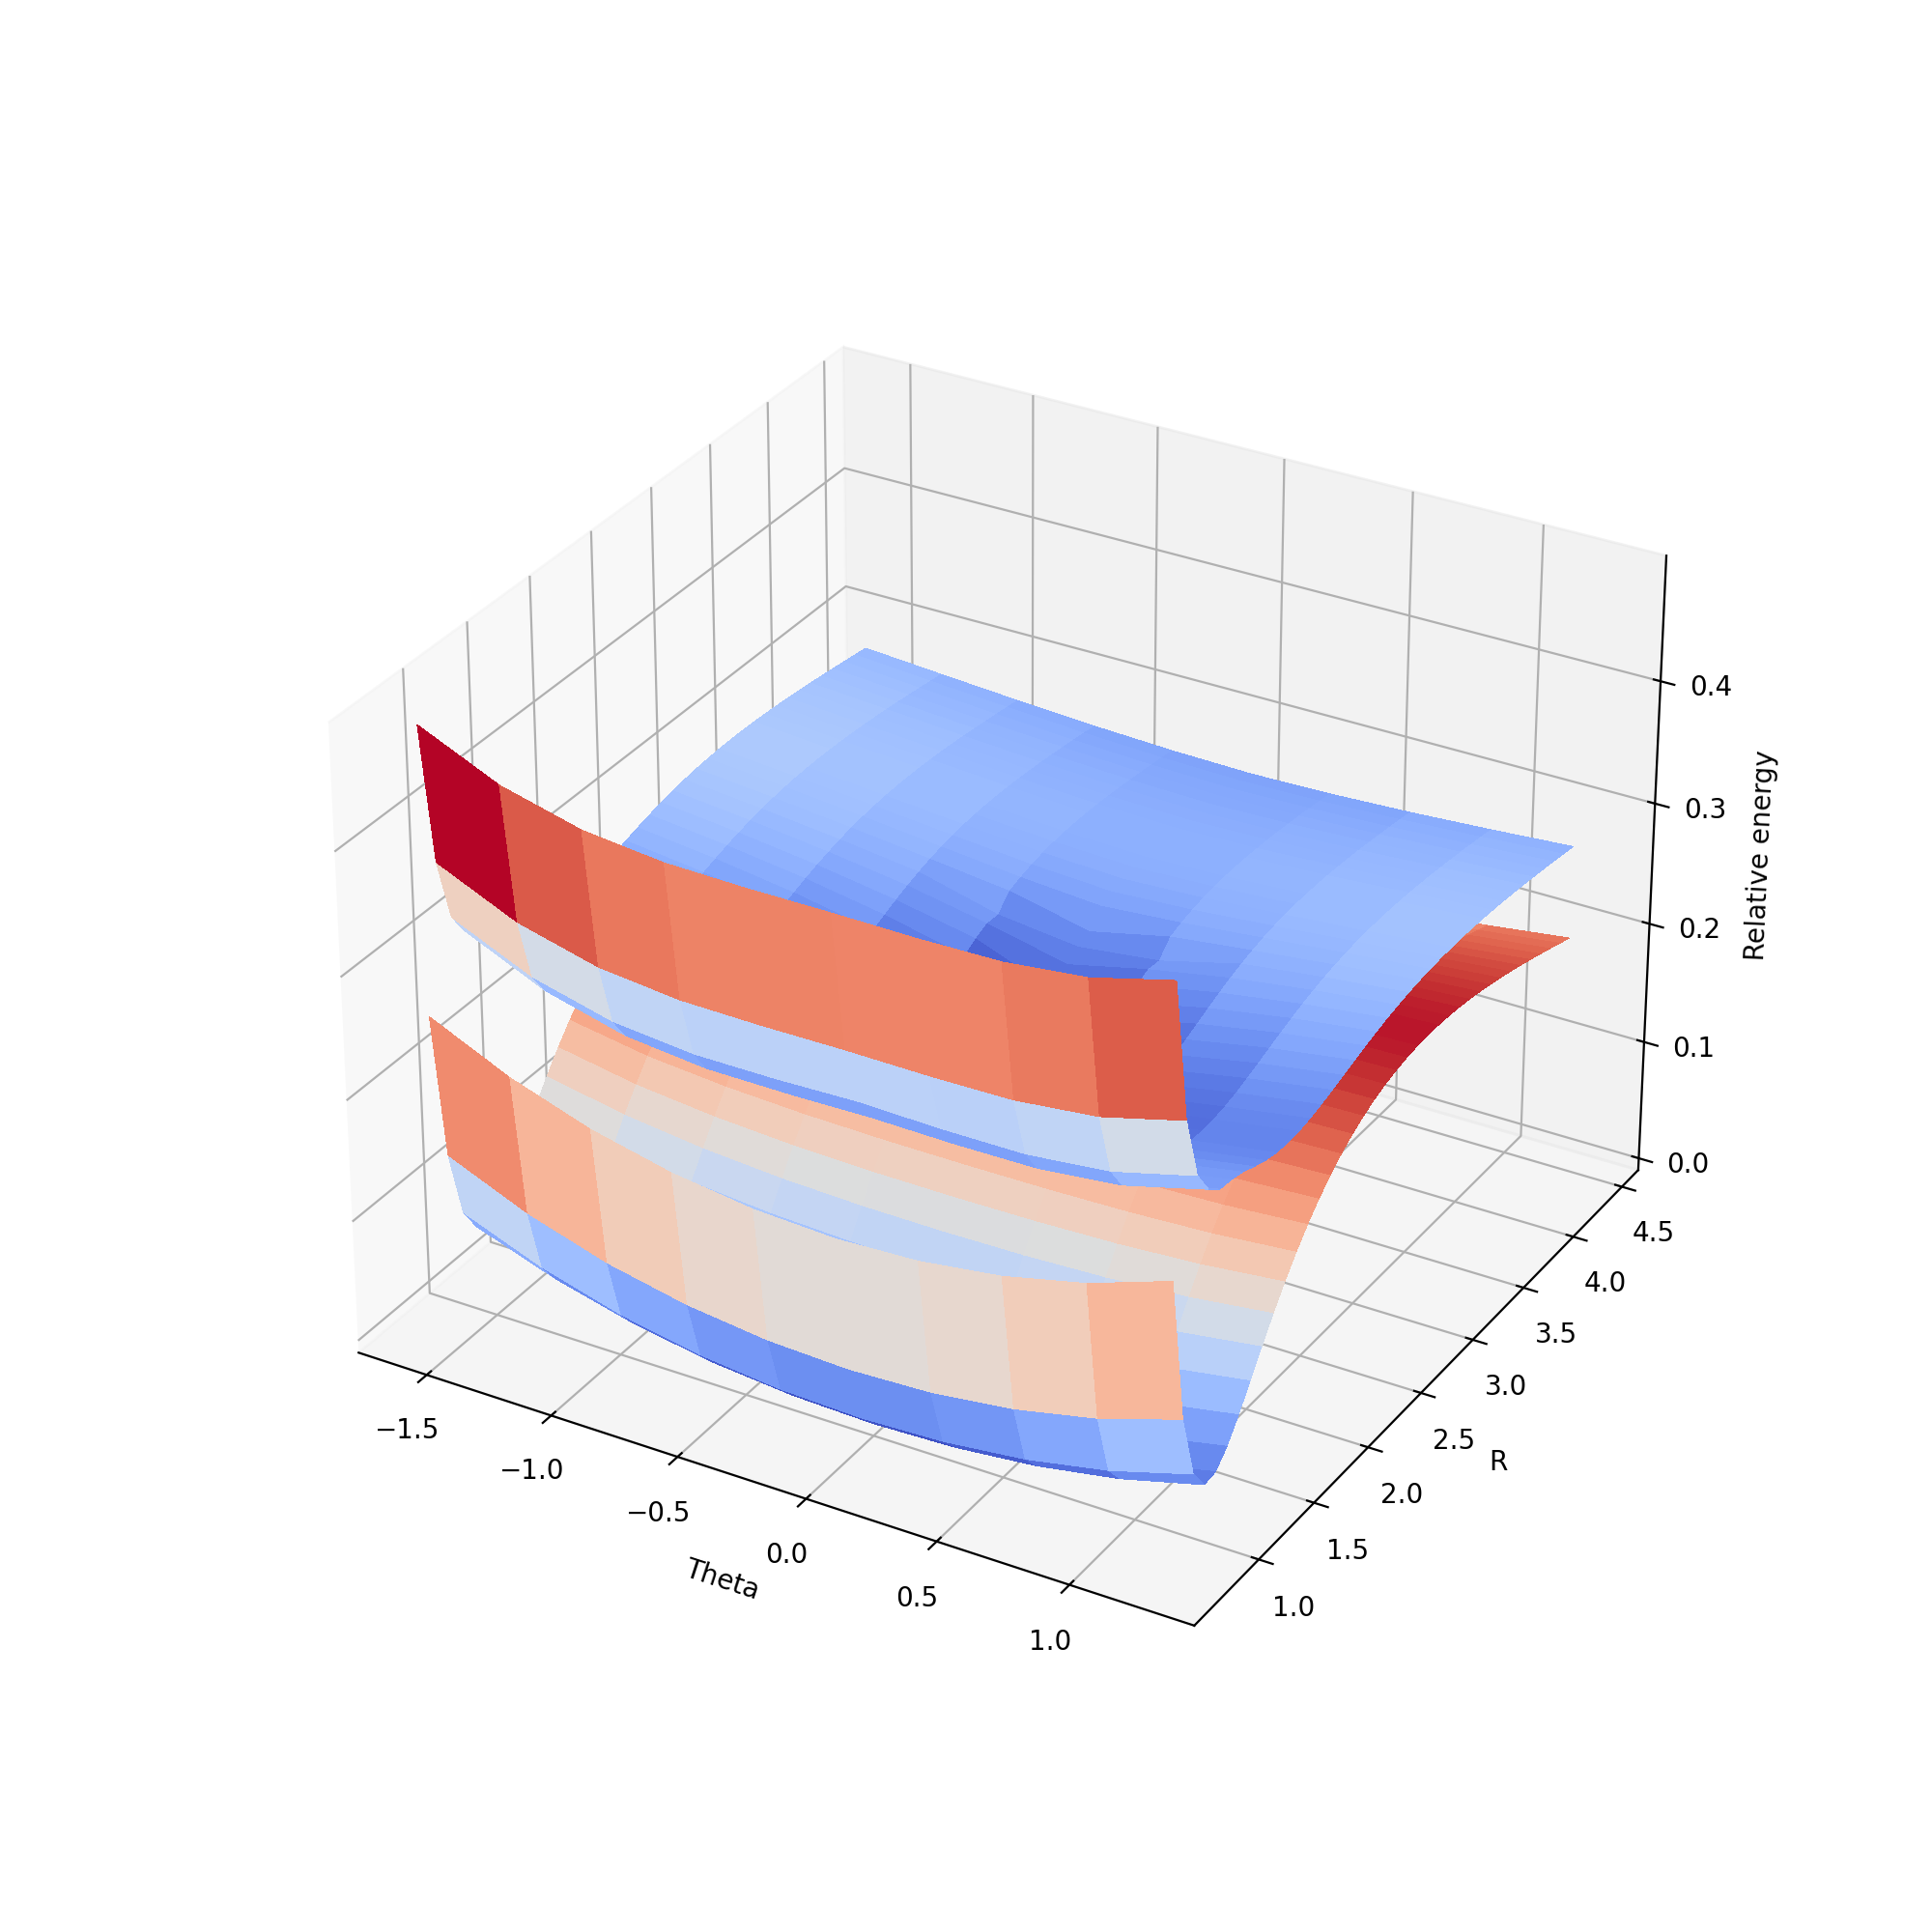

Text(0.5, 0, 'Relative energy')

In [153]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))

surf1 = ax.plot_surface(Theta, R, data1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf2 = ax.plot_surface(Theta, R, data2, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel('Theta')
ax.set_ylabel('R')
ax.set_zlabel('Relative energy')


<IPython.core.display.Javascript object>


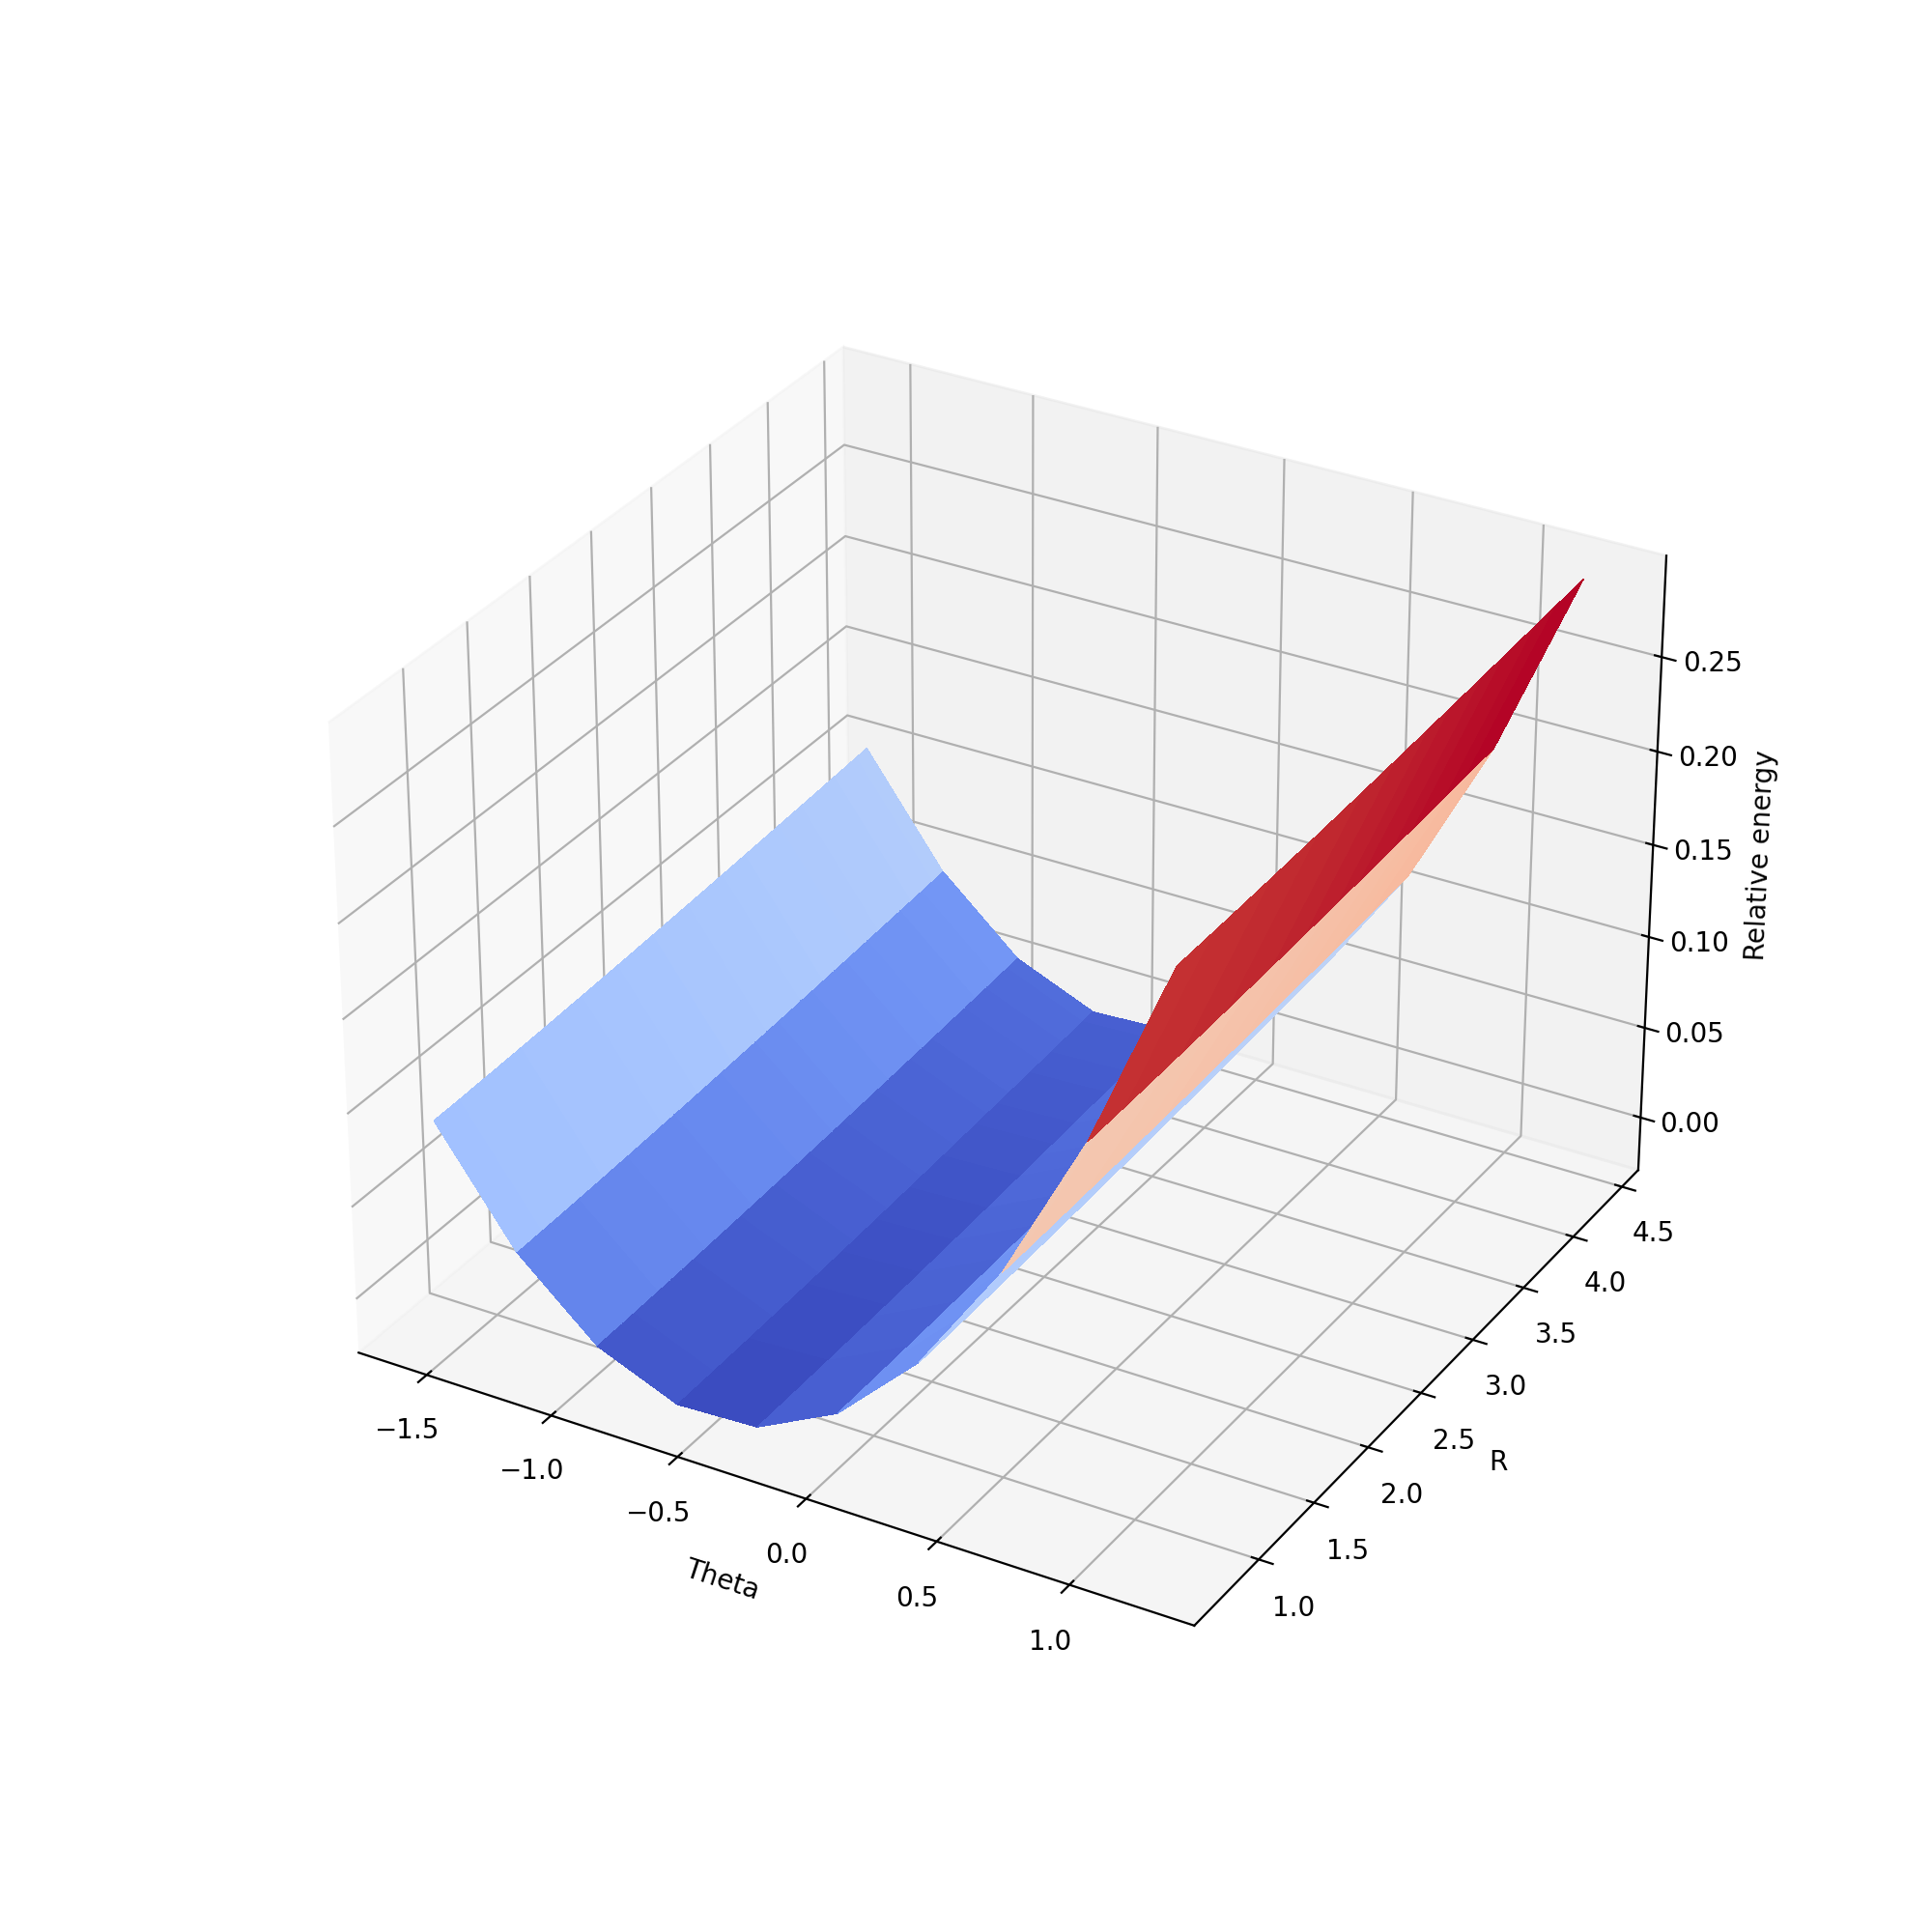

In [155]:

Theta, R = np.meshgrid(theta, r)

data1 = np.loadtxt('GS_pes.txt').reshape(len(r), len(theta))
data2 = np.loadtxt('ES2_pes.txt').reshape(len(r), len(theta))

Theta_tf = tf.convert_to_tensor(Theta)
R_tf = tf.convert_to_tensor(R)
data1_tf = tf.convert_to_tensor(data1)
data2_tf = tf.convert_to_tensor(data2)

def morse_potential(R, D_e, alp, r_e):
    exp_term = tf.exp(-alp * (R - r_e))
    return D_e * (1 - exp_term) ** 2

def ho(Theta, a, b, x0):
    return a * (Theta - x0)**2 + b * (Theta - x0)

def diab_funct(Theta, R, D_e, alp, r_e, a, b, x0, e0):
    return morse_potential(R, D_e, alp, r_e) + ho(Theta, a, b, x0) + e0

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf1 = ax.plot_surface(Theta, R, diab_funct(Theta, R, 0.1, 0.1, 0.0, 0.1, 0.1, 0.0, 0.0), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('Theta')
ax.set_ylabel('R')
ax.set_zlabel('Relative energy')
plt.show()


In [308]:



lam = tf.Variable(0.1, dtype=tf.float64)
guess_params = tf.Variable([0.17630392, 2.16081026 ,1.04002022,
                            1.47742318e-02,  1.54614038e-07, -2.08993993e-02,     1.1,
                            -0.96104706,  5.57247967e+00 ,0.05,
                            0.02018354, 0.01929044 ,0.53008601,  .2,
                            0.1], dtype=tf.float64)


guess_params = tf.Variable([2.68735319e-01,  2.16081026e+00,  1.04002022e+00,  8.03464355e-03,
        1.37997373e-04,  3.01747122e-02, -6.93750619e-03, -4.67559370e-01,
        5.57247967e+00,  5.00000000e-02,  1.75162765e-02,  2.29655120e-02,
        6.38086079e-01,  6.93118320e-01, 0.6], dtype=tf.float64)
# @tf.function
def cost_tf(data1, data2, Theta,R,*parameters):
    Theta = tf.convert_to_tensor(Theta, dtype=tf.float64)
    R = tf.convert_to_tensor(R, dtype=tf.float64)

    # Calculate morse
    w11 = diab_state(Theta, R, *parameters[:7])
    w22 = diab_state(Theta, R, *parameters[7:-1])

    # Calculate lam values
    w12 = parameters[-1]*Theta

    # Stack tensor
    filled_tensor = tf.stack([w11, w12, w12, w22], axis=2)
    filled_tensor = tf.reshape(filled_tensor, [np.shape(Theta)[0], np.shape(Theta)[1], 2, 2])

    # Calculate eigenvalues
    eigenvalues = tf.linalg.eigvalsh(filled_tensor)
    global evec
    eigenvalues, evec = tf.linalg.eigh(filled_tensor)
    global v
    v = evec@filled_tensor@ tf.transpose(evec, perm=[0, 1, 3, 2])

    # Data to tensor form
    data1_tensor = tf.convert_to_tensor(data1, dtype=tf.float64)
    data2_tensor = tf.convert_to_tensor(data2, dtype=tf.float64)

    # Error from difference squared
    loss = tf.reduce_sum(tf.square(eigenvalues - tf.stack([data1_tensor, data2_tensor], axis=2)))

    # Curvature error
    # hessian_trace_c1 = 0
    # hessian_trace_c2 = 0
    # a, b = np.gradient(w11)
    # aa = np.gradient(a)
    # bb = np.gradient(b)
    # aa = tf.convert_to_tensor(aa+bb)
    # aa = tf.reduce_sum(tf.abs(aa))
    # with tf.GradientTape() as t2:
    #     with tf.GradientTape() as t1:
    #         c1_error = diab_state(Theta, R, *parameters[:7])
        # c2_error = diab_state(Theta, R, *parameters[7:])
        # First derivative with respect to the current parameter
    #     g1_first_derivative  = t1.gradient(c1_error,  parameters[:7])
    #g1_second_derivative = t2.gradient(g1_first_derivative,  parameters[:7])
        #g2_first_derivative = tape2.gradient(c2_error, param)
    
    # Add the second derivative to the trace sum
    #hessian_trace_c1 += g1_second_derivative
    #hessian_trace_c2 += g2_second_derivative
    # print(g1_first_derivative)
    # del t1

    # Delete the persistent tape manually
    #del tape1

    return loss



In [335]:
# Analytic (Beyond Born-Oppenheimer...)
# Annu. Rev. Phys. Chem 2004 55:127-58

#@tf.function
def morse_tf(x, q, m, u, v):
    return q * (1 - tf.exp(-m * (x - u)))**2 +v

# @tf.function
def diab_state(Theta, R,  xx1, m1, r01, a1, b1, theta01, e01):
    return xx1 * (1 - np.exp(-m1 * (R - r01)))**2 + a1 * (Theta - theta01)**2 + b1 * (Theta - theta01) + e01



lam = tf.Variable(0.1, dtype=tf.float64)

guess_params = tf.Variable([0.17630392, 2.16081026 ,1.04002022,
                            1.47742318e-02,  1.54614038e-07, -2.08993993e-02,     1.1,
                            -0.96104706,  5.57247967e+00 ,0.05,
                            0.02018354, 0.01929044 ,0.53008601,  .2,
                            0.1], dtype=tf.float64)
# @tf.function
def cost_tf(data1, data2, Theta,R,*parameters):
    Theta = tf.convert_to_tensor(Theta, dtype=tf.float64)
    R = tf.convert_to_tensor(R, dtype=tf.float64)

    # Calculate morse
    w11 = diab_state(Theta, R, *parameters[:7])
    w22 = diab_state(Theta, R, *parameters[7:-1])

    # Calculate lam values
    w12 = parameters[-1]*Theta

    sigma = 0.5 * (w11 + w22)
    delta = 0.5 * (w22 - w11)
    global v1
    global v2

    v2 = sigma + tf.sqrt(delta**2 + w12**2)
    v1 = sigma - tf.sqrt(delta**2 + w12**2)

    # Data to tensor form
    data1_tensor = tf.convert_to_tensor(data1, dtype=tf.float64)
    data2_tensor = tf.convert_to_tensor(data2, dtype=tf.float64)

    # Error from difference squared
    loss = tf.reduce_sum(tf.square(tf.stack([v1,v2], axis=2) - tf.stack([data1_tensor, data2_tensor], axis=2)))
    # loss = tf.reduce_sum(tf.abs(tf.stack([v1, v2], axis=2) - tf.stack([data1_tensor, data2_tensor], axis=2)))
    # loss = tf.reduce_sum(tf.math.log(tf.cosh(tf.stack([v1, v2], axis=2) - tf.stack([data1_tensor, data2_tensor], axis=2))))

    return loss



In [336]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
        y = x * x * x

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
    dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


In [337]:
w11 = diab_state(Theta, R, *guess_params[:7])
w22 = diab_state(Theta, R, *guess_params[7:-1])
lam = tf.Variable(0.1, dtype=tf.float64)
w12 = guess_params[-1]*Theta

a, b = np.gradient(w11)
aa = np.gradient(a)
bb = np.gradient(b)



In [338]:
np.shape(Theta)[0]

38

In [339]:
filled_tensor = tf.stack([w11, w12, w12, w22], axis=2)
filled_tensor = tf.reshape(filled_tensor, [np.shape(Theta)[0], np.shape(Theta)[1], 2, 2])
eigenvalues = tf.linalg.eigvalsh(filled_tensor)
data1_tensor = tf.convert_to_tensor(data1, dtype=tf.float64)
data2_tensor = tf.convert_to_tensor(data2, dtype=tf.float64)
print(np.shape(data2_tensor))
loss = tf.reduce_sum(tf.square(eigenvalues - tf.stack([data1_tensor, data2_tensor], axis=2)))
loss

(38, 10)


<tf.Tensor: shape=(), dtype=float64, numpy=690.9712964840049>

In [340]:
cost_tf(data1, data2, Theta,R,*guess_params)

<tf.Tensor: shape=(), dtype=float64, numpy=690.9712964840048>

In [341]:

with tf.GradientTape() as tape:
    loss = cost_tf(data1, data2, Theta,R,*guess_params)
gradients = tape.gradient(loss, [guess_params])
del tape
gradients

[<tf.Tensor: shape=(15,), dtype=float64, numpy=
 array([ 577.82317394,    0.        ,    0.        ,  619.21103039,
        -101.18120627,    2.98963425,  743.42572426, -693.69142884,
           0.        ,    0.        , -887.41484209,  475.12693442,
          -5.75782672, -695.76745013,  120.95582312])>]

In [342]:
print(guess_params)

<tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
array([ 1.76303920e-01,  2.16081026e+00,  1.04002022e+00,  1.47742318e-02,
        1.54614038e-07, -2.08993993e-02,  1.10000000e+00, -9.61047060e-01,
        5.57247967e+00,  5.00000000e-02,  2.01835400e-02,  1.92904400e-02,
        5.30086010e-01,  2.00000000e-01,  1.00000000e-01])>


In [343]:
# Optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=6000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Set up early stopping parameters
early_stopping_threshold = 1e-4
patience = 50
best_loss = float('inf')
wait = 0

# ML loop
num_epochs = 6000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        # Compute the loss
        loss = cost_tf(data1, data2, Theta,R,*guess_params)
        
    # Get gradients
    gradients = tape.gradient(loss, [guess_params])
    # print(gradients)
    del tape
    # Update variables
    optimizer.apply_gradients(zip(gradients, [guess_params]))

    # Early stopping check
    if (loss < best_loss - early_stopping_threshold):
        best_loss = loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(" Not gonna improve")
            break
        
    # Print loss each 100 steps
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

Epoch 0, Loss: 690.9712964840048
Epoch 100, Loss: 11.318366657547397
Epoch 200, Loss: 5.716184832966079
Epoch 300, Loss: 4.071455918692552
Epoch 400, Loss: 3.0825676399775874
Epoch 500, Loss: 2.543485588419652
Epoch 600, Loss: 2.2957550510816804
Epoch 700, Loss: 2.162113565094827
Epoch 800, Loss: 2.014290264194032
Epoch 900, Loss: 1.8364740930581491
Epoch 1000, Loss: 1.1599744207393514
Epoch 1100, Loss: 0.5835373245208691
Epoch 1200, Loss: 0.4476293941069554
Epoch 1300, Loss: 0.4164302054211946
Epoch 1400, Loss: 0.41019690768247785
Epoch 1500, Loss: 0.4091161156072297
Epoch 1600, Loss: 0.4089372692665978
 Not gonna improve


In [344]:
guess_params

<tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
array([ 2.68735319e-01,  2.16081026e+00,  1.04002022e+00,  8.03464355e-03,
        1.37997373e-04,  3.01747122e-02, -6.93750619e-03, -4.67559370e-01,
        5.57247967e+00,  5.00000000e-02,  1.75162765e-02,  2.29655120e-02,
        6.38086079e-01,  6.93118320e-01, -2.67890967e-02])>

In [345]:
# v1 = v[:,:,0,0]
# v2 = v[:,:,1,1]
# v1

In [346]:
surf1 = ax.plot_surface(Theta, R, v1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf1 = ax.plot_surface(Theta, R, v2, cmap=cm.coolwarm, linewidth=0, antialiased=False)

In [347]:
guess_params

<tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
array([ 2.68735319e-01,  2.16081026e+00,  1.04002022e+00,  8.03464355e-03,
        1.37997373e-04,  3.01747122e-02, -6.93750619e-03, -4.67559370e-01,
        5.57247967e+00,  5.00000000e-02,  1.75162765e-02,  2.29655120e-02,
        6.38086079e-01,  6.93118320e-01, -2.67890967e-02])>

<IPython.core.display.Javascript object>


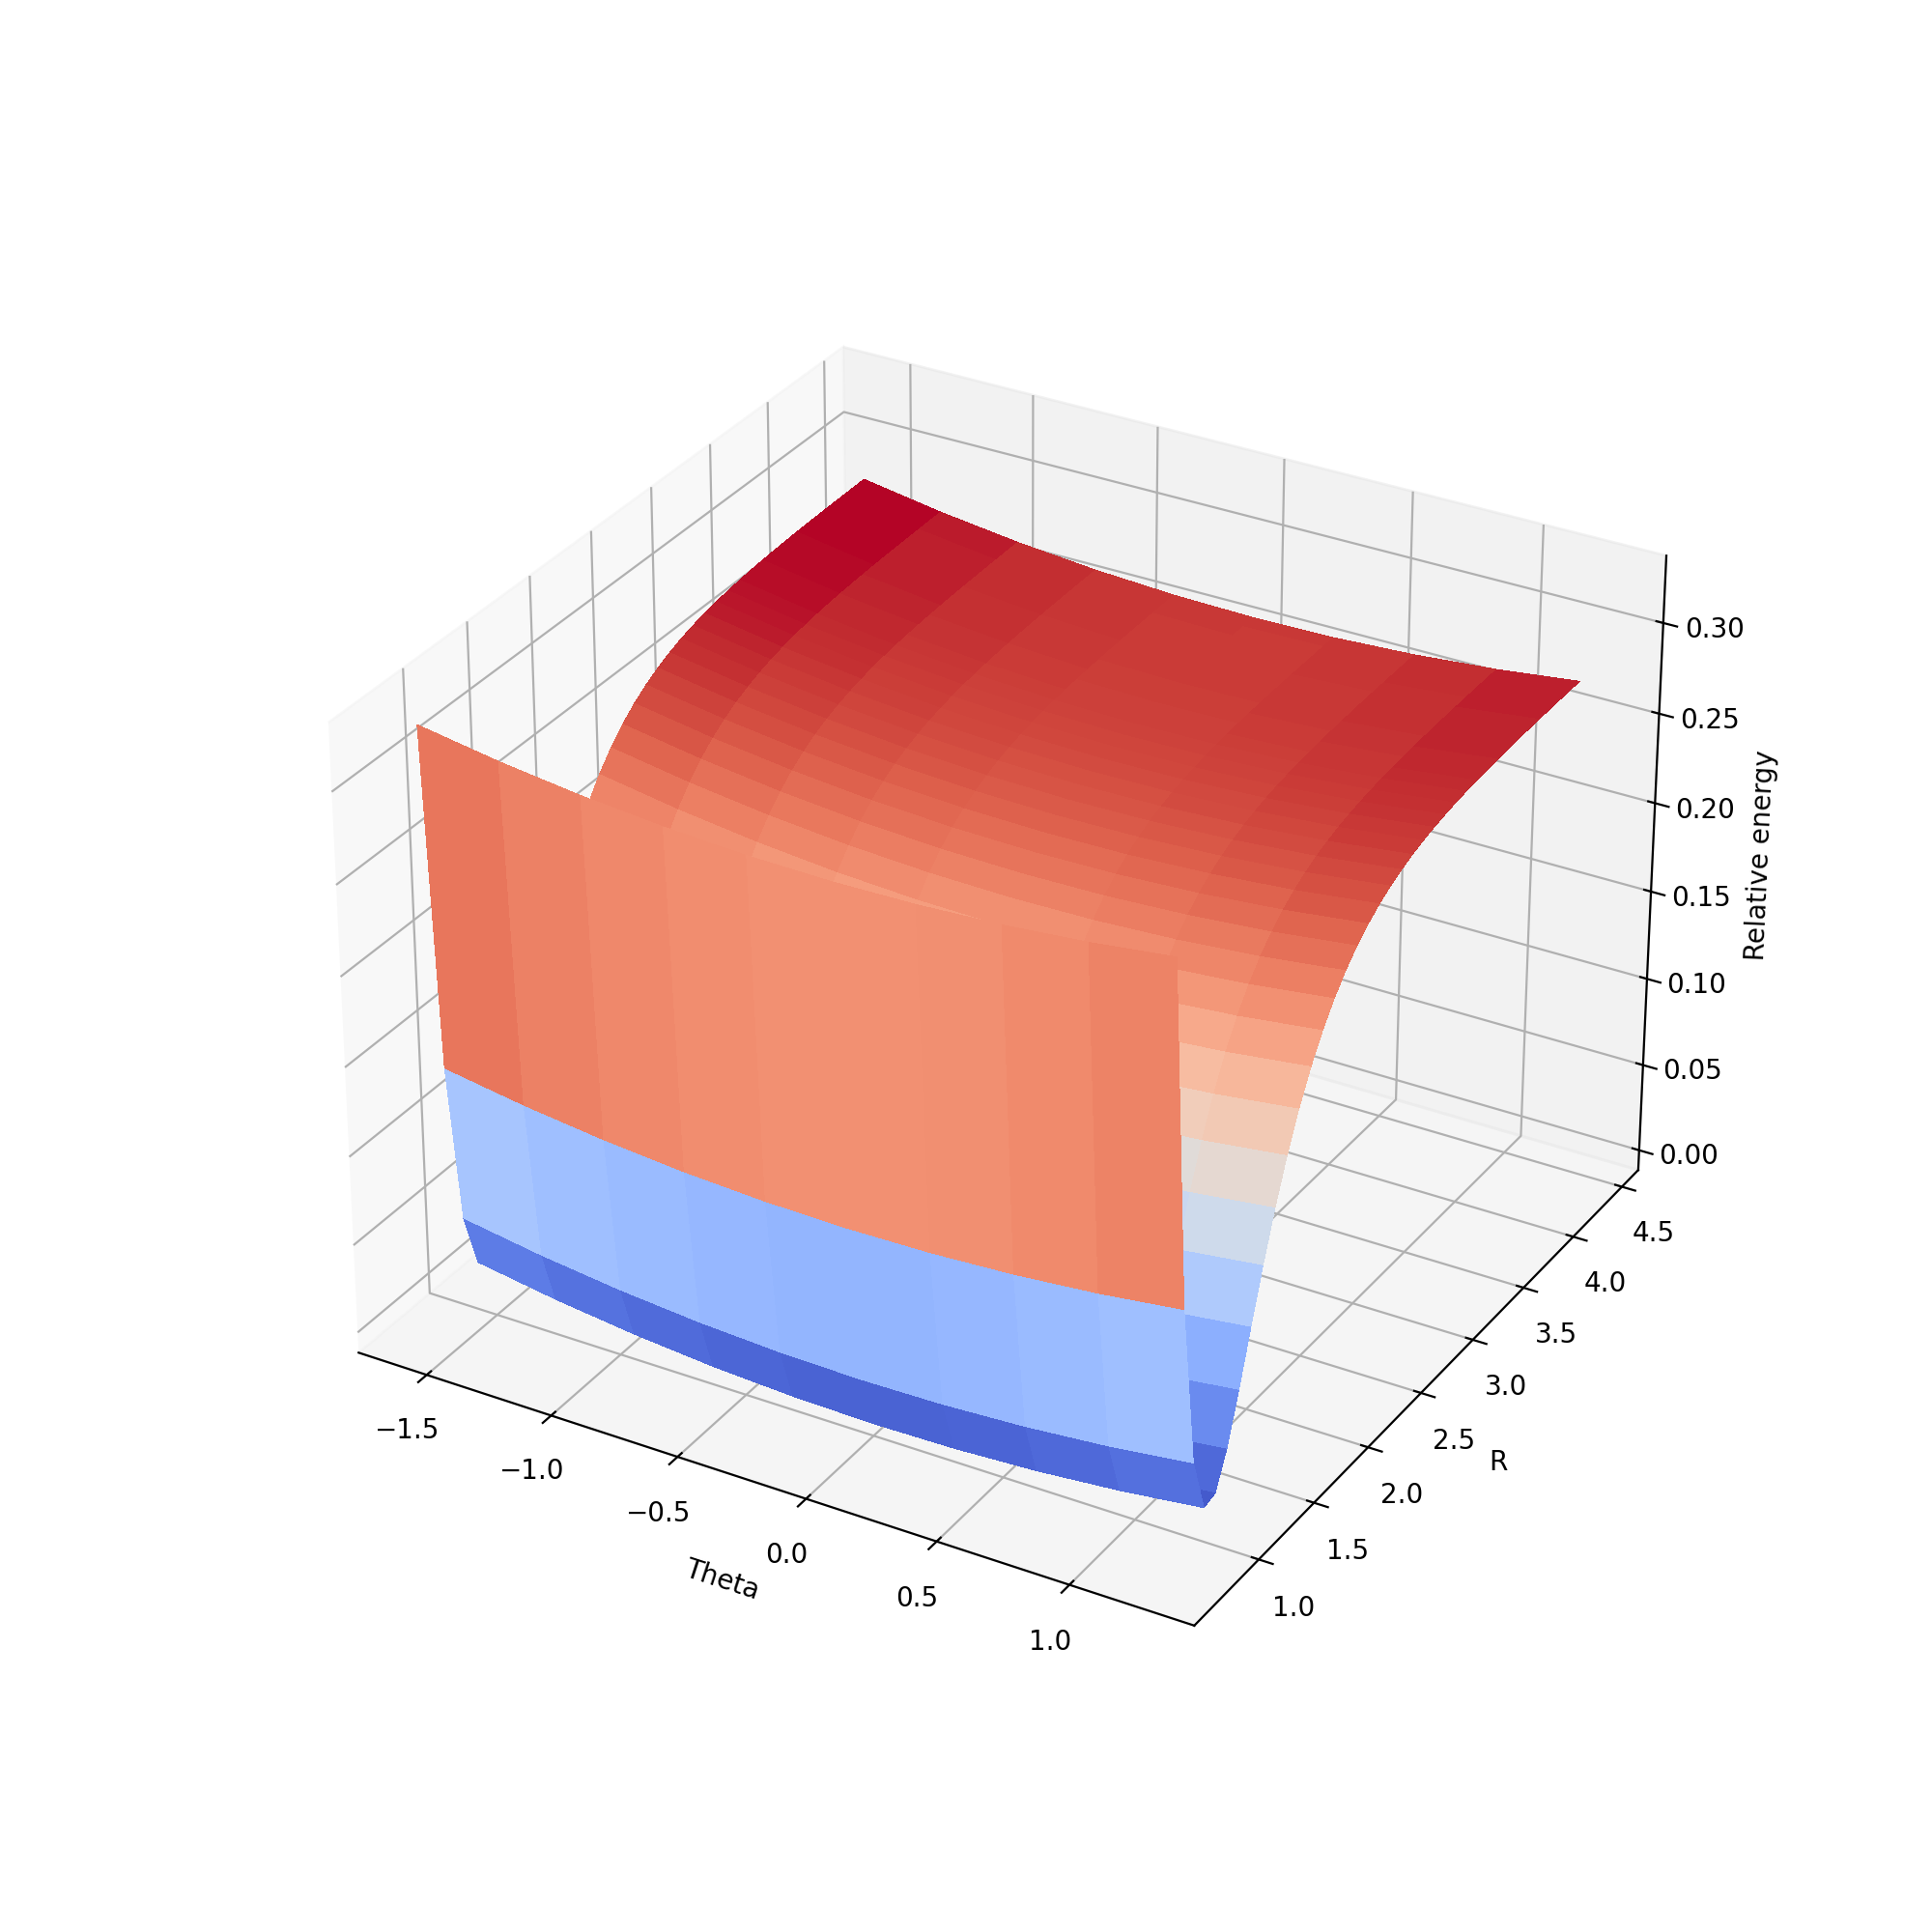

In [349]:
# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf1 = ax.plot_surface(Theta, R, diab_funct(Theta, R,*guess_params[:7]), cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf1 = ax.plot_surface(Theta, R, diab_funct(Theta, R,*guess_params[7:-1]), cmap=cm.coolwarm, linewidth=0, antialiased=False)
# surf1 = ax.plot_surface(Theta, R, v1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# surf1 = ax.plot_surface(Theta, R, v2, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# surf1 = ax.plot_surface(Theta, R, data1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# surf1 = ax.plot_surface(Theta, R, data2, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('Theta')
ax.set_ylabel('R')
ax.set_zlabel('Relative energy')
plt.show()

<IPython.core.display.Javascript object>


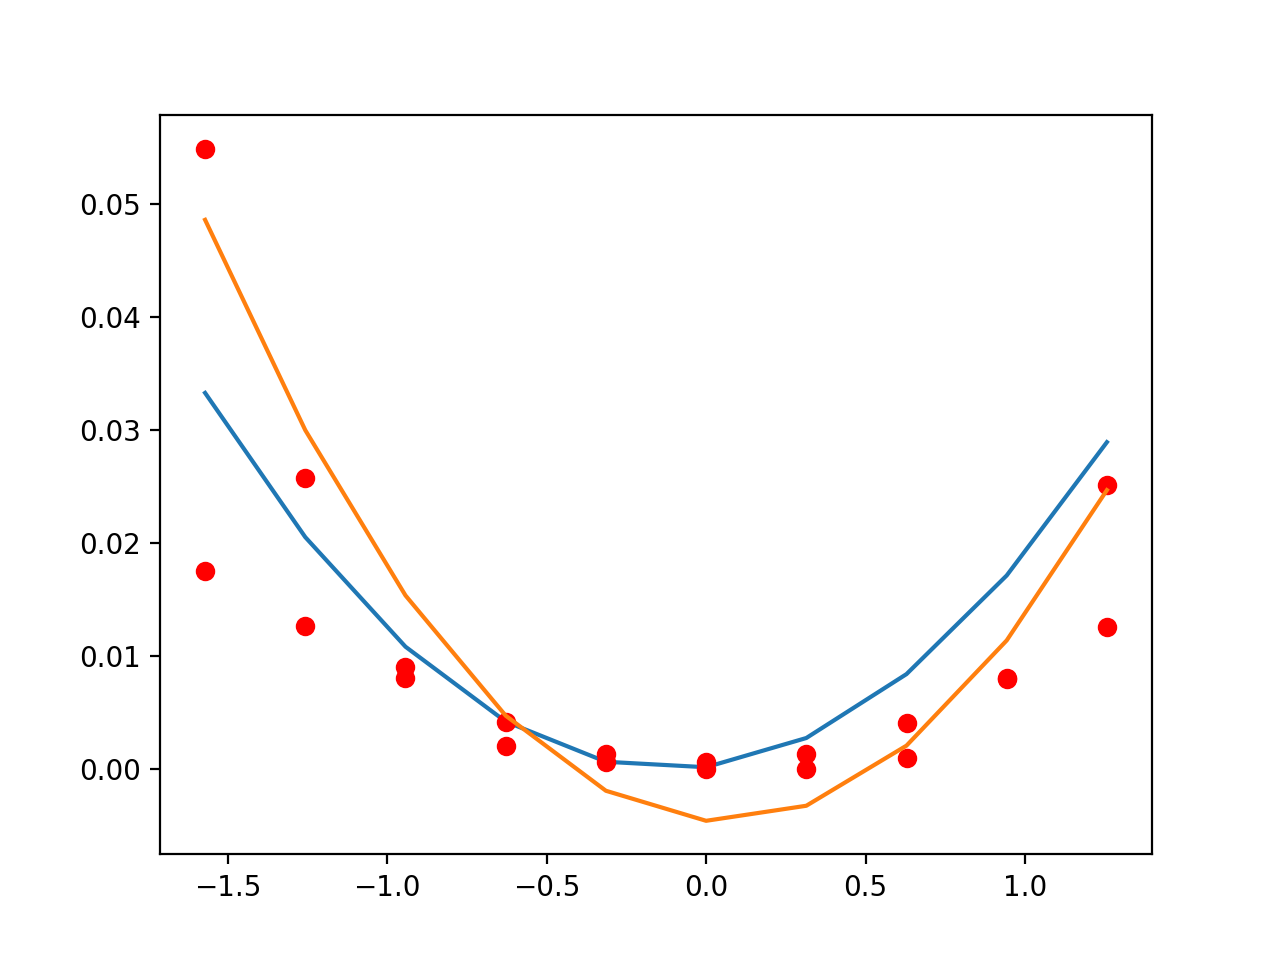

In [81]:
def morse(x, q, m, u):
    return (q * (np.exp(-2*m*(x-u))-2*np.exp(-m*(x-u))))
plt.figure()
plt.plot(theta,ho(theta, 1.55346772e-02 ,-4.04154770e-07 ,-1.07541640e-01) )
plt.plot(theta, data2[-1,:]-data2[-1,:].min(),"ro")
plt.show()

[0.02806706 2.11275146 1.31379205]


<IPython.core.display.Javascript object>


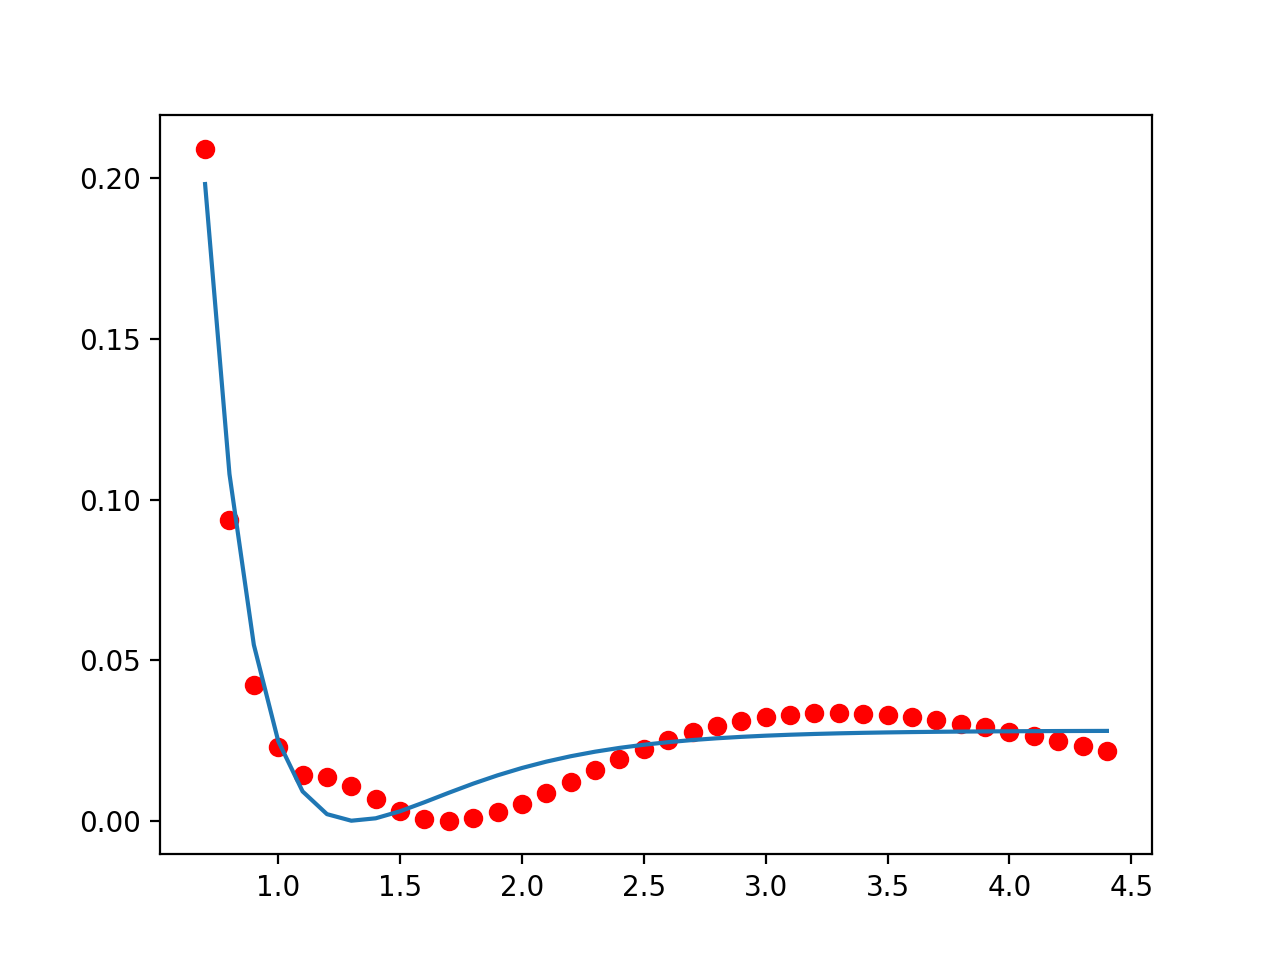

In [135]:
from scipy.optimize import curve_fit
def morse(x, q, m, u):
    return q * (1 - np.exp(-m * (x - u)))**2

data1 = data1
data2 = data2
popt, pcov = curve_fit(morse, r, data2[:,-1]- data2[:,-1].min(), p0 = [4.96104706e-01, 10.57247967e+00 ,1.5],  maxfev=40000000)
# popt, pcov = curve_fit( ho, theta, data1[-1,:]-data1[-1,:].min(), p0 =[1.55346772e-02 ,-4.04154770e-07 ,-1.07541640e-01] )
print(popt)

#yfit = morse(r,popt[0], popt[1], popt[2],popt[3])
yfit = morse(r,popt[0], popt[1], popt[2])

#print popt
#
#
#
plt.figure()
# plt.plot(theta, data1[-1,:]-data1[-1,:].min(),"ro")
plt.plot(r, data2[:,-1]-data2[:,-1].min(),"ro")
plt.plot(r, yfit)


<IPython.core.display.Javascript object>


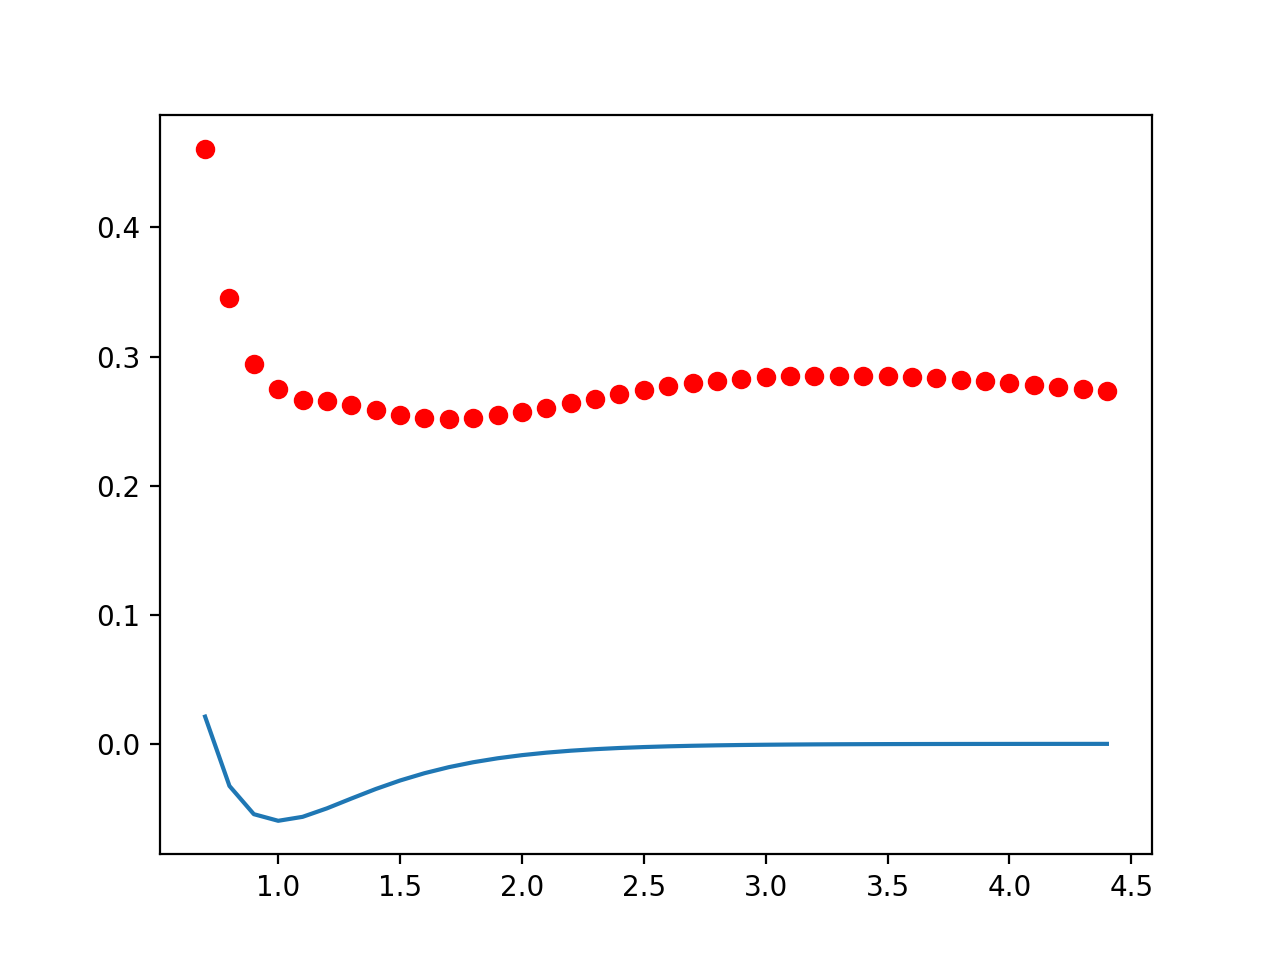

In [133]:
plt.figure()

plt.plot(r, data2[:,-1],"ro")
plt.plot(r, morse(r,5.96104706e-02, 2.57247967e+00 ,1.))

In [355]:
# Output data
w11 = diab_funct(Theta, R,*guess_params[:7]).numpy().reshape(len(r)*len(theta))
w22 = diab_funct(Theta, R,*guess_params[7:-1]).numpy().reshape(len(r)*len(theta))
w12 = (guess_params[-1]*Theta).numpy().reshape(len(r)*len(theta))

In [358]:
np.savetxt("w11.dat",w11)
np.savetxt("w22.dat",w22)
np.savetxt("w12.dat",w12)